<a href="https://colab.research.google.com/github/qonitah-sarah/womens-ecommerce-review-analysis/blob/main/Tokenize_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tokenize Text

In [ ]:
# import library
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('data_sentiment_WClothReview.csv')

In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,fill_review,Rating_category,nps_category,sentiment
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Reviewed,Satisfied,Promoter,Positive
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Reviewed,Best,Promoter,Positive
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Reviewed,Neutral,Detractor,Neutral
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Reviewed,Best,Promoter,Positive
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Reviewed,Best,Promoter,Positive


In [ ]:
%%capture
import nltk

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

!pip install contractions

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import contractions

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Create more detailed text cleansing
def clean_tokenize_text(x):
  # lower text
  out_text = x.lower()
  # clean double whitespace
  out_text = ' '.join(out_text.split())
  # clean url
  out_text = re.sub(r"http\S+|www\S+|https\S+", 'http', out_text)
  # clean username
  out_text = re.sub(r"@\S+", '@user', out_text)
  # remove punctuation
  out_text = out_text.translate(str.maketrans('', '', string.punctuation))
  # fix word contraction: don't -> do not
  out_text = contractions.fix(out_text)
  # tokenize the text
  tokens = word_tokenize(out_text)
  # exclude stop words
  tokens = [word for word in tokens if word not in stop_words]
  # lematize tokens: cats -> cat
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  return(tokens)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
 11  fill_review              23486 non-null  object
 12  Rating_category          22641 non-null  object
 13  nps_category             22641 non-null  object
 14  sentiment                22641 non-nul

In [ ]:
# Example
clean_tokenize_text('This   product sparks joy. You should try it!')

['product', 'spark', 'joy', 'try']

In [ ]:
%%time
df_token = df[['Unnamed: 0', 'sentiment', 'Review Text']].copy()

df_token = df_token.dropna(subset=['Review Text'])

df_token['token'] = df_token['Review Text'].apply(clean_tokenize_text)

df_token = df_token.explode('token')

df_token = df_token[['Unnamed: 0', 'token', 'sentiment']]

df_token.head()

CPU times: user 14.4 s, sys: 83.3 ms, total: 14.4 s
Wall time: 21.6 s


,Unnamed: 0,token,sentiment
0,0,absolutely,Positive
0,0,wonderful,Positive
0,0,silky,Positive
0,0,sexy,Positive
0,0,comfortable,Positive


In [ ]:
df_token.to_csv('data_token_WClothReview.csv', index=False)

## Text Visualization: Word Cloud

In [ ]:
# Only check for positive and negative sentiment
df_top_word = df_token[df_token['sentiment'] != 'Neutral' ]
df_top_word = df_top_word.groupby(['sentiment', 'token']).agg({'Unnamed: 0':'nunique'}).reset_index()

# Get top 50 words
df_top_word = df_top_word.sort_values(['sentiment', 'Unnamed: 0'], ascending = [False, False])
df_top_word = df_top_word.groupby('sentiment').head(50)

df_top_word.head()

,sentiment,token,Unnamed: 0
11150,Positive,fit,7199
13865,Positive,love,6975
18029,Positive,size,5794
10215,Positive,dress,5335
8848,Positive,color,5219


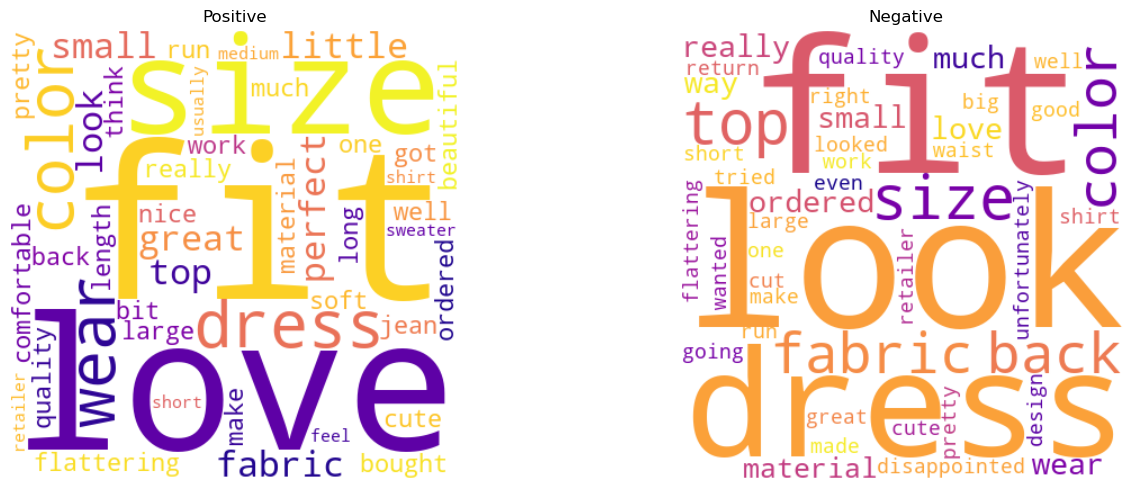

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

groups = df_top_word['sentiment'].unique()

# Set up the plot
fig, axes = plt.subplots(1, len(groups), figsize=(15, 5), squeeze=False)

# Generate word clouds for each group
for idx, group in enumerate(groups):
    text = " ".join(df_top_word[ df_top_word['sentiment'] == group]['token'])
    wordcloud = WordCloud(width=400, height=400,
                          background_color='white',
                          colormap = 'plasma'
                          ).generate(text)

    # Display the word cloud
    axes[0, idx].imshow(wordcloud, interpolation='bilinear')
    axes[0, idx].set_title(f"{group}")
    axes[0, idx].axis('off')

plt.tight_layout()
plt.show()

## Tokenize with Bi-gram

In [ ]:
from nltk.util import bigrams

def clean_tokenize_bigram(x):
  # lower text
  out_text = x.lower()
  # clean double whitespace
  out_text = ' '.join(out_text.split())
  # clean url
  out_text = re.sub(r"http\S+|www\S+|https\S+", 'http', out_text)
  # clean username
  out_text = re.sub(r"@\S+", '@user', out_text)
  # remove punctuation
  out_text = out_text.translate(str.maketrans('', '', string.punctuation))
  # fix word contraction: don't -> do not
  out_text = contractions.fix(out_text)
  # tokenize the text
  tokens = word_tokenize(out_text)
  # exclude stop words
  tokens = [word for word in tokens if word not in stop_words]
  # lematize tokens: cats -> cat
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Create bigrams
  tokens = list(bigrams(tokens))

  # Join bigrams into single strings
  tokens = ['_'.join(pair) for pair in tokens]

  return(tokens)

clean_tokenize_bigram("I love this apple")


['love_apple']

In [ ]:
%%time
df_token = df[['Unnamed: 0', 'sentiment', 'Review Text']].copy()

df_token = df_token.dropna(subset=['Review Text'])

df_token['token'] = df_token['Review Text'].apply(clean_tokenize_bigram)

df_token = df_token.explode('token')

df_token = df_token[['Unnamed: 0', 'token', 'sentiment']]

df_token.head()

CPU times: total: 9.11 s
Wall time: 9.54 s


,Unnamed: 0,token,sentiment
0,0,absolutely_wonderful,Positive
0,0,wonderful_silky,Positive
0,0,silky_sexy,Positive
0,0,sexy_comfortable,Positive
1,1,love_dress,Positive


In [ ]:
# Only check for positive and negative sentiment
df_top_word = df_token[df_token['sentiment'] != 'Neutral' ]
df_top_word = df_top_word.groupby(['sentiment', 'token']).agg({'Unnamed: 0':'nunique'}).reset_index()

# Get top 50 words
df_top_word = df_top_word.sort_values(['sentiment', 'Unnamed: 0'], ascending = [False, False])
df_top_word = df_top_word.groupby('sentiment').head(20)

df_top_word.head()

,sentiment,token,Unnamed: 0
248868,Positive,true_size,1205
117821,Positive,fit_perfectly,1008
156736,Positive,look_great,836
159326,Positive,love_dress,662
254728,Positive,usually_wear,589


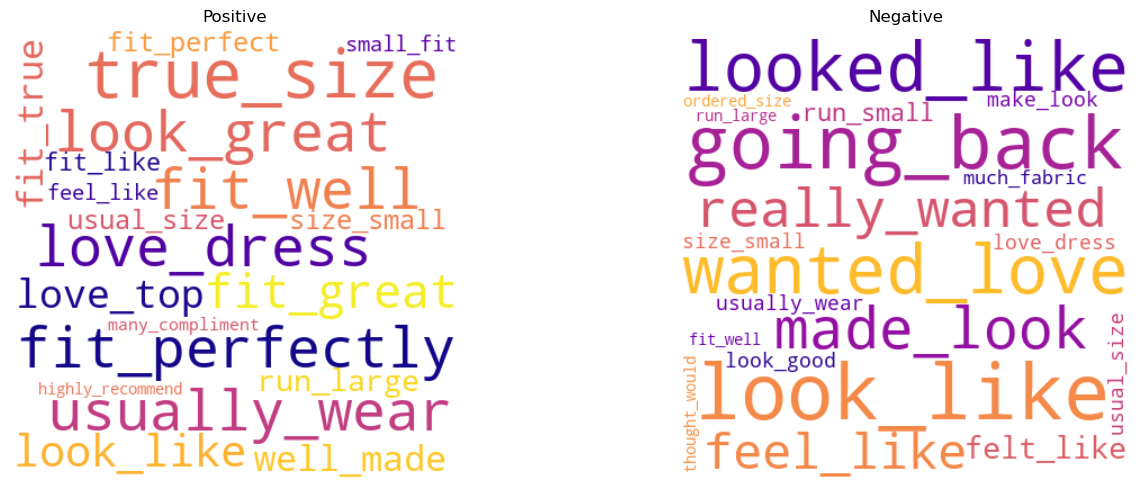

In [ ]:
groups = df_top_word['sentiment'].unique()

# Set up the plot
fig, axes = plt.subplots(1, len(groups), figsize=(15, 5), squeeze=False)

# Generate word clouds for each group
for idx, group in enumerate(groups):
    text = " ".join(df_top_word[ df_top_word['sentiment'] == group]['token'])
    wordcloud = WordCloud(width=400, height=400,
                          background_color='white',
                          colormap = 'plasma'
                          ).generate(text)

    # Display the word cloud
    axes[0, idx].imshow(wordcloud, interpolation='bilinear')
    axes[0, idx].set_title(f"{group}")
    axes[0, idx].axis('off')

plt.tight_layout()
plt.show()